# Experiment2: Pseudo Labelling

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [23]:
## Common Utility Functions

def calculate_accuracy(loader,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  

    return 100 * correct / total


def trainAndPlot(model,labeled_loader, unlabeled_loader, b_alpha,  num_epochs, readingAtEpoch, lr):

    # Lists to store metrics
    supervised_losses = []
    unsupervised_losses = []
    train_accuracies = []
    test_accuracies = []

    # Variable to store the best test accuracy
    best_test_accuracy = 0.0
    best_epoch = 0

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # Train on labeled data
        for labeled_batch, unlabeled_batch in zip(labeled_loader, unlabeled_loader):
            # Unpack labeled data
            l_images, l_labels = labeled_batch
        
            
            # Forward pass for labeled data
            optimizer.zero_grad()
            l_outputs = model(l_images)
            l_loss = criterion(l_outputs, l_labels)
            
            # Unpack unlabeled data
            u_images, _ = unlabeled_batch

            # Forward pass for unlabeled data (pseudo-labeling)
            with torch.no_grad():
                u_outputs = model(u_images)
            u_labels = torch.argmax(u_outputs, dim=1)

            # Calculate loss for unlabeled data (consider using a balancing coefficient)
            u_loss = criterion(u_outputs, u_labels)

            # Combine losses and backpropagate
            total_loss = l_loss + b_alpha * u_loss  # b_alpha is your balancing coefficient
            total_loss.backward()
            optimizer.step()


        if epoch%readingAtEpoch==0:

            supervised_loss_value = l_loss.item()
            unsupervised_loss_value = u_loss.item()
            train_accuracy_value = calculate_accuracy(labeled_loader, model)
            test_accuracy_value = calculate_accuracy(unlabeled_loader, model)

            if test_accuracy_value > best_test_accuracy:
                best_test_accuracy = test_accuracy_value
                best_epoch = epoch


            supervised_losses.append(supervised_loss_value)
            unsupervised_losses.append(unsupervised_loss_value)
            train_accuracies.append(train_accuracy_value)
            test_accuracies.append(test_accuracy_value)

            print(f"Epoch {epoch}: Supervised Loss: {supervised_loss_value}, "
                f"Unsupervised Loss: {unsupervised_loss_value}, "
                f"Labeled Accuracy: {train_accuracy_value}, "
                f"UnLabeled Accuracy: {test_accuracy_value}")
            

    epochs = range(0,num_epochs, readingAtEpoch)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, supervised_losses, label='Supervised Loss')
    plt.plot(epochs, unsupervised_losses, label='Psedu Label Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')

    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Labeled Accuracy')
    plt.plot(epochs, test_accuracies, label='UnLabeled Accuracy')
    plt.scatter(best_epoch, best_test_accuracy, color='red')
    plt.text(best_epoch, best_test_accuracy, f'Best: {best_test_accuracy:.2f}% at Epoch {best_epoch}', 
             horizontalalignment='left', verticalalignment='bottom')
    plt.ylim(0,110)
    plt.title('Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### MNIST Data

In [24]:
# Load the labeled data from the .npz file
data = np.load('./Saved_Data/labeled_dataset_MNIST.npz')
labeled_images = data['images']
labled_labels = data['labels']

# Convert data to PyTorch tensors
labeled_images = torch.tensor(labeled_images, dtype=torch.float32)
labled_labels = torch.tensor(labled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
labeled_dataset = TensorDataset(labeled_images, labled_labels)
labeled_dataloaderMnist = DataLoader(labeled_dataset, batch_size=10, shuffle=True)

# Load the un-labeled data from the .npz file
data = np.load('./Saved_Data/unlabeled_dataset_MNIST.npz')
unlabeled_images = data['images']
unlabeled_labels = data['labels']

# Convert data to PyTorch tensors
unlabeled_images = torch.tensor(unlabeled_images, dtype=torch.float32)
unlabeled_labels = torch.tensor(unlabeled_labels, dtype=torch.long)

# Create a TensorDataset and DataLoader
unlabeled_dataset = TensorDataset(unlabeled_images, unlabeled_labels)
unlabeled_dataloaderMnist = DataLoader(unlabeled_dataset, batch_size=50, shuffle=True)

In [14]:
class MnistNet(nn.Module):

    def __init__(self):

        super(MnistNet,self).__init__()
        self.flatten = nn.Flatten()
        self.fullyConnectedLayer = nn.Sequential(
            
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200,10)
        )

    def forward(self, input):
        
        input = self.flatten(input)
        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput
    

Epoch 0: Supervised Loss: 2.3210103511810303, Unsupervised Loss: 2.1826469898223877, Labeled Accuracy: 10.0, UnLabeled Accuracy: 10.0
Epoch 10: Supervised Loss: 0.9742653965950012, Unsupervised Loss: 0.9690811634063721, Labeled Accuracy: 83.0, UnLabeled Accuracy: 61.282828282828284
Epoch 20: Supervised Loss: 0.47321438789367676, Unsupervised Loss: 0.5304033756256104, Labeled Accuracy: 98.0, UnLabeled Accuracy: 68.95959595959596
Epoch 30: Supervised Loss: 0.0964617133140564, Unsupervised Loss: 0.35590699315071106, Labeled Accuracy: 100.0, UnLabeled Accuracy: 69.96969696969697
Epoch 40: Supervised Loss: 0.046826500445604324, Unsupervised Loss: 0.27679339051246643, Labeled Accuracy: 100.0, UnLabeled Accuracy: 71.02020202020202
Epoch 50: Supervised Loss: 0.019486239179968834, Unsupervised Loss: 0.27576878666877747, Labeled Accuracy: 100.0, UnLabeled Accuracy: 71.07070707070707
Epoch 60: Supervised Loss: 0.01673005148768425, Unsupervised Loss: 0.27298611402511597, Labeled Accuracy: 100.0, U

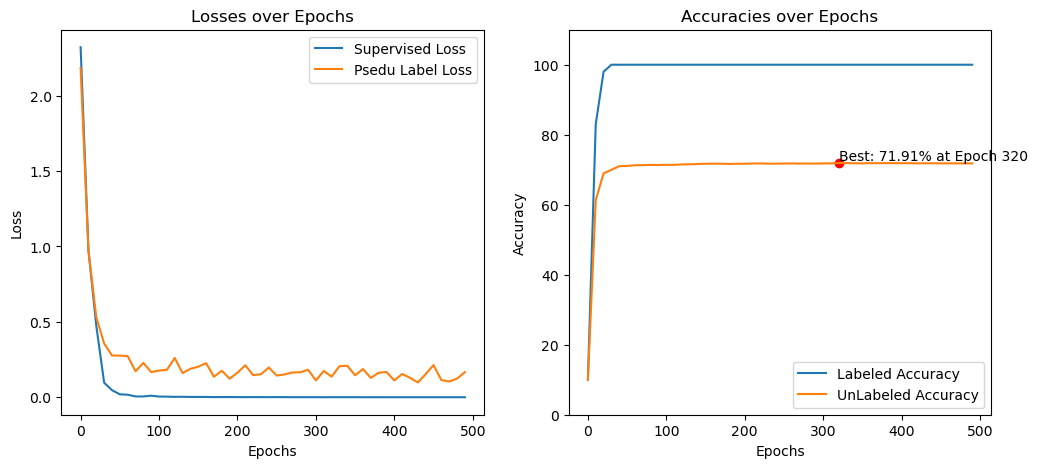

In [29]:
model1 = MnistNet()

trainAndPlot(
    model = model1,
    labeled_loader=labeled_dataloaderMnist,
    unlabeled_loader=unlabeled_dataloaderMnist,
    b_alpha=0.1,
    num_epochs=500,
    readingAtEpoch=10,
    lr = 0.02
)

###  Two Moons Dataset

In [30]:
selected_samples = np.load('./Saved_Data/labeled_dataset_TwoMoons.npy')

remaining_samples = np.load('./Saved_Data/unlabeled_dataset_TwoMoons.npy')

# Converting the selected samples and remaining samples into PyTorch tensors
selected_samples_tensor = torch.tensor(selected_samples, dtype=torch.float32)
remaining_samples_tensor = torch.tensor(remaining_samples, dtype=torch.float32)

# Extracting features and labels for both datasets
features_selected = selected_samples_tensor[:, :2]
labels_selected = selected_samples_tensor[:, 2].long()  # converting labels to long for classification

features_remaining = remaining_samples_tensor[:, :2]
labels_remaining = remaining_samples_tensor[:, 2].long()

# Creating TensorDatasets
selected_dataset = TensorDataset(features_selected, labels_selected)
remaining_dataset = TensorDataset(features_remaining, labels_remaining)

# Creating DataLoaders
labeled_dataloaderTM = DataLoader(selected_dataset, batch_size=1)  # small batch size for the small dataset
unlabeled_dataloaderTM = DataLoader(remaining_dataset, batch_size=5)  # larger batch size for the larger dataset

In [39]:
class TwoMoonsNet(nn.Module):

    def __init__(self):

        super(TwoMoonsNet,self).__init__()

        self.fullyConnectedLayer = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10,2)
        )

    def forward(self, input):

        output = self.fullyConnectedLayer(input)
        activatedOutput = F.log_softmax(output, dim = 1)

        return activatedOutput

Epoch 0: Supervised Loss: 1.4557011127471924, Unsupervised Loss: 0.27682656049728394, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 2: Supervised Loss: 1.4124857187271118, Unsupervised Loss: 0.2905595600605011, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 4: Supervised Loss: 1.365584135055542, Unsupervised Loss: 0.30634427070617676, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 6: Supervised Loss: 1.3208082914352417, Unsupervised Loss: 0.32234886288642883, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 8: Supervised Loss: 1.2790849208831787, Unsupervised Loss: 0.33815163373947144, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 10: Supervised Loss: 1.2405140399932861, Unsupervised Loss: 0.35358232259750366, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 12: Supervised Loss: 1.2049721479415894, Unsupervised Loss: 0.3685511648654938, Labeled Accuracy: 50.0, UnLabeled Accuracy: 50.0
Epoch 14: Supervised Loss: 1.1722744703292847, Unsupervi

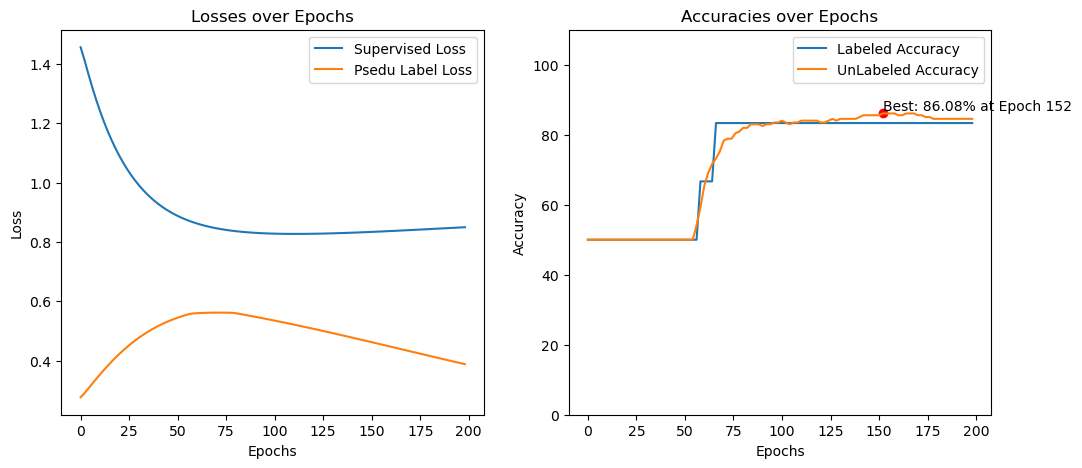

In [40]:
PseudoModel_TwoMoons = TwoMoonsNet()


trainAndPlot(
    model = PseudoModel_TwoMoons,
    labeled_loader=labeled_dataloaderTM,
    unlabeled_loader=unlabeled_dataloaderTM,
    b_alpha=0.1,
    num_epochs=200,
    readingAtEpoch=2,
    lr = 0.001
)


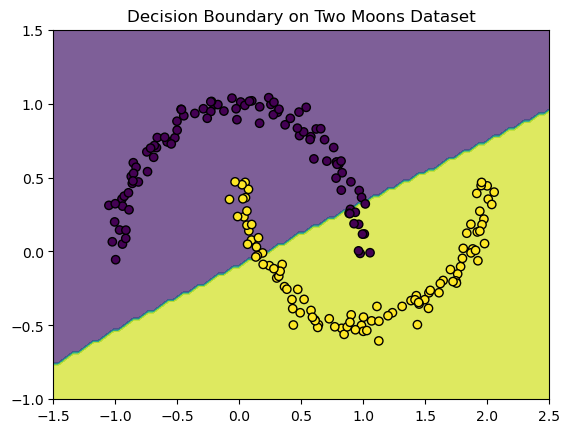

In [41]:
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

PseudoModel_TwoMoons.eval()
with torch.no_grad():
    predictions = PseudoModel_TwoMoons(grid_tensor)
    classes = torch.argmax(predictions, dim=1).numpy().reshape(xx.shape)

plt.contourf(xx, yy, classes, alpha=0.7)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_samples[:, 2], edgecolor='k')
plt.scatter(remaining_samples[:, 0], remaining_samples[:, 1], c=remaining_samples[:, 2], edgecolor='k')
plt.title("Decision Boundary on Two Moons Dataset")
plt.show()